In [177]:
from ydata_profiling import ProfileReport
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import json

%matplotlib inline


In [178]:
df_acceptance = pd.read_csv("data/Globepay Acceptance Report..csv", delimiter=";")
df_chargeback = pd.read_csv("data/Globepay Chargeback Report ..csv")

In [179]:
df_acceptance.head()

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,rates
0,nCyEIIGaP5QQ2Wqb-_Rt8,True,GLOBALPAY,evt_1ESgcCOV7fY1ChY1MkZizZt,2019-01-01T00:00:00.000Z,DECLINED,False,1020.46,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
1,ptNiI9B7NNpK7VsMZx6zZ,True,GLOBALPAY,evt_1EBMGCEjEtianKMJaZXOx1y,2019-01-01T04:48:00.000Z,ACCEPTED,False,1582.57,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
2,1GS5BDKBnauCt-3nHPs6x,True,GLOBALPAY,evt_1EOALu0AZqEhZBn9ub_nbcE,2019-01-01T09:36:00.000Z,DECLINED,False,1653.07,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
3,Y_oecYz8GjBDaxmMqkkLQ,True,GLOBALPAY,evt_1ESHsWyaSPqE1mrmJ2B6rvs,2019-01-01T14:24:00.000Z,ACCEPTED,False,2228.17,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
4,LlEs1TnKVa2xX6PH9Zsz0,True,GLOBALPAY,evt_1EjzPk13qLzmvDR_4hXuMMw,2019-01-01T19:12:00.000Z,ACCEPTED,False,2589.92,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."


In [180]:
df_chargeback.head()

,external_ref,status,source,chargeback
0,_-UTDS0dMlagMWEtQKMy-,True,GLOBALPAY,False
1,_0fqf75KiPa0iiviKCSsU,True,GLOBALPAY,False
2,_0H9Ecd_RctsLetId-p14,True,GLOBALPAY,False
3,_0wBrMzAzIhO3fQRWUcBH,True,GLOBALPAY,False
4,_25jZuGDrmwUEdAwKp1xV,True,GLOBALPAY,False


# EDA

In [181]:
report_acceptance = ProfileReport(df_acceptance, title="Acceptance Report")
report_chargeback = ProfileReport(df_chargeback, title="Chargeback Report")

report_acceptance.to_file("eda_reports/report_acceptance.html")
report_chargeback.to_file("eda_reports/report_chargeback.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 919.00it/s]


# Some first remarks after EDA
- No missing values in any column
- status and source columns are constant and can be ignored for this analysis
- external ref and ref columns are unique ids. external_ref of chargeback report and acceptance report can be used to merge the two files.
- dates provided between 01/01/2019 and 30/01/2029 (Q1 + Q2 2019). Also, we are dealing with 30 transactions a day. Column needs to be formatted.
- state var can be changed to a boolean "is_accepted"
- cvv_provided == True in <1% of cases
- Each country has the same number of transactions in this dataset
- AE charged in USD.
- Amounts in USD can be calculated from currency, amount, and rates
- chargeback rate of 4.1% overall
- The potentially relevant dimensions for this analysis are "date_time", "state", "cvv_provided", "amount_usd" (to be generated), "country", "chargeback"

In [182]:
df_merged = df_chargeback[["external_ref", "chargeback"]].merge(df_acceptance, how="outer", on="external_ref")

# Check if merge successfull
assert df_merged.isnull().sum().sum() == 0

In [183]:
df = df_merged[["date_time", "state", "cvv_provided", "amount", "country", "currency", "rates", "chargeback"]]
df["rates"] = df["rates"].apply(json.loads) #convert to dict
df["date_time"] = pd.to_datetime(df['date_time'])
df['is_accepted'] = df['state'].apply(lambda x: True if x=="ACCEPTED" else False)

df.head()

/var/folders/jc/1hl9c7nx1h15zywjnz8mmrd00000gn/T/ipykernel_19878/4004550812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rates"] = df["rates"].apply(json.loads) #convert to dict
/var/folders/jc/1hl9c7nx1h15zywjnz8mmrd00000gn/T/ipykernel_19878/4004550812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_time"] = pd.to_datetime(df['date_time'])
/var/folders/jc/1hl9c7nx1h15zywjnz8mmrd00000gn/T/ipykernel_19878/4004550812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,date_time,state,cvv_provided,amount,country,currency,rates,chargeback,is_accepted
0,2019-04-10 14:24:00+00:00,ACCEPTED,False,88213.76,UK,GBP,"{'CAD': 1.3968516836979044, 'EUR': 0.834701869...",False,True
1,2019-06-05 00:00:00+00:00,DECLINED,False,153745.33,AE,USD,"{'CAD': 1.373884159861163, 'EUR': 0.7073791490...",False,False
2,2019-02-23 04:48:00+00:00,ACCEPTED,False,47968.63,UK,GBP,"{'CAD': 1.4103084164144004, 'EUR': 0.874631208...",False,True
3,2019-04-19 00:00:00+00:00,DECLINED,False,93297.21,UK,GBP,"{'CAD': 1.3856144803380648, 'EUR': 0.771612534...",False,False
4,2019-02-01 00:00:00+00:00,DECLINED,False,34806.95,AE,USD,"{'CAD': 1.3990597645348972, 'EUR': 0.863863910...",False,False


# Task 1: Analytics skills
(Note - This task aims to test your Analytics skills)
Please create a comprehensive report (presentation/keynote/PDF) that covers the following points:
- Present the volume of declined payments in USD
- Analyse the root causes for the decline in the acceptance rate
- Provide well-justified solutions, recommendations, and next steps that you would take if given
more time, additional data, and deeper business knowledge.

## a) Present the volume of declined payments in USD

In [184]:
# Volume of declined payments
df["amount_usd"] = df.apply(lambda x: x["amount"]/x["rates"][x["currency"]], axis=1)

df_declined = df[df['state'] == 'DECLINED']
total_declined_usd = df_declined['amount_usd'].sum()
df_not_declined = df[df['state'] != 'DECLINED']
total_not_declined_usd = df_not_declined['amount_usd'].sum()
print(f"Total declined payments in USD: {total_declined_usd:.2f}")
print(f"Total not declined payments in USD: {total_not_declined_usd:.2f}")

Total declined payments in USD: 132672780.85
Total not declined payments in USD: 297598730.39


/var/folders/jc/1hl9c7nx1h15zywjnz8mmrd00000gn/T/ipykernel_19878/4293841358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["amount_usd"] = df.apply(lambda x: x["amount"]/x["rates"][x["currency"]], axis=1)


## Result
- There are 132,672,780.85 USD out of 430.271.511,24 USD, resulting in an overall ~69% acceptance rate. 
- Note that chargeback (more later) only occurs for accepted payments and therefore wasn't taken into account
- This number seems quite low in general

## Next Steps
- Let's segment the data according to different time criteria to learn more about the root cause for a recent dip in acceptance rate

In [185]:
# Let's segment the data according to different time criteria to learn more about the root cause
df['date'] = df['date_time'].dt.date.copy()
df['day_of_month'] = df['date_time'].dt.day
df["day_of_week"] = df["date_time"].dt.day_of_week
df['hour_of_day'] = df['date_time'].dt.hour

df.head()

/var/folders/jc/1hl9c7nx1h15zywjnz8mmrd00000gn/T/ipykernel_19878/970761694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date_time'].dt.date.copy()


,date_time,state,cvv_provided,amount,country,currency,rates,chargeback,is_accepted,amount_usd,date,day_of_month,day_of_week,hour_of_day
0,2019-04-10 14:24:00+00:00,ACCEPTED,False,88213.76,UK,GBP,"{'CAD': 1.3968516836979044, 'EUR': 0.834701869...",False,True,123326.930134,2019-04-10,10,2,14
1,2019-06-05 00:00:00+00:00,DECLINED,False,153745.33,AE,USD,"{'CAD': 1.373884159861163, 'EUR': 0.7073791490...",False,False,153745.330000,2019-06-05,5,2,0
2,2019-02-23 04:48:00+00:00,ACCEPTED,False,47968.63,UK,GBP,"{'CAD': 1.4103084164144004, 'EUR': 0.874631208...",False,True,61494.107708,2019-02-23,23,5,4
3,2019-04-19 00:00:00+00:00,DECLINED,False,93297.21,UK,GBP,"{'CAD': 1.3856144803380648, 'EUR': 0.771612534...",False,False,129900.262527,2019-04-19,19,4,0
4,2019-02-01 00:00:00+00:00,DECLINED,False,34806.95,AE,USD,"{'CAD': 1.3990597645348972, 'EUR': 0.863863910...",False,False,34806.950000,2019-02-01,1,4,0


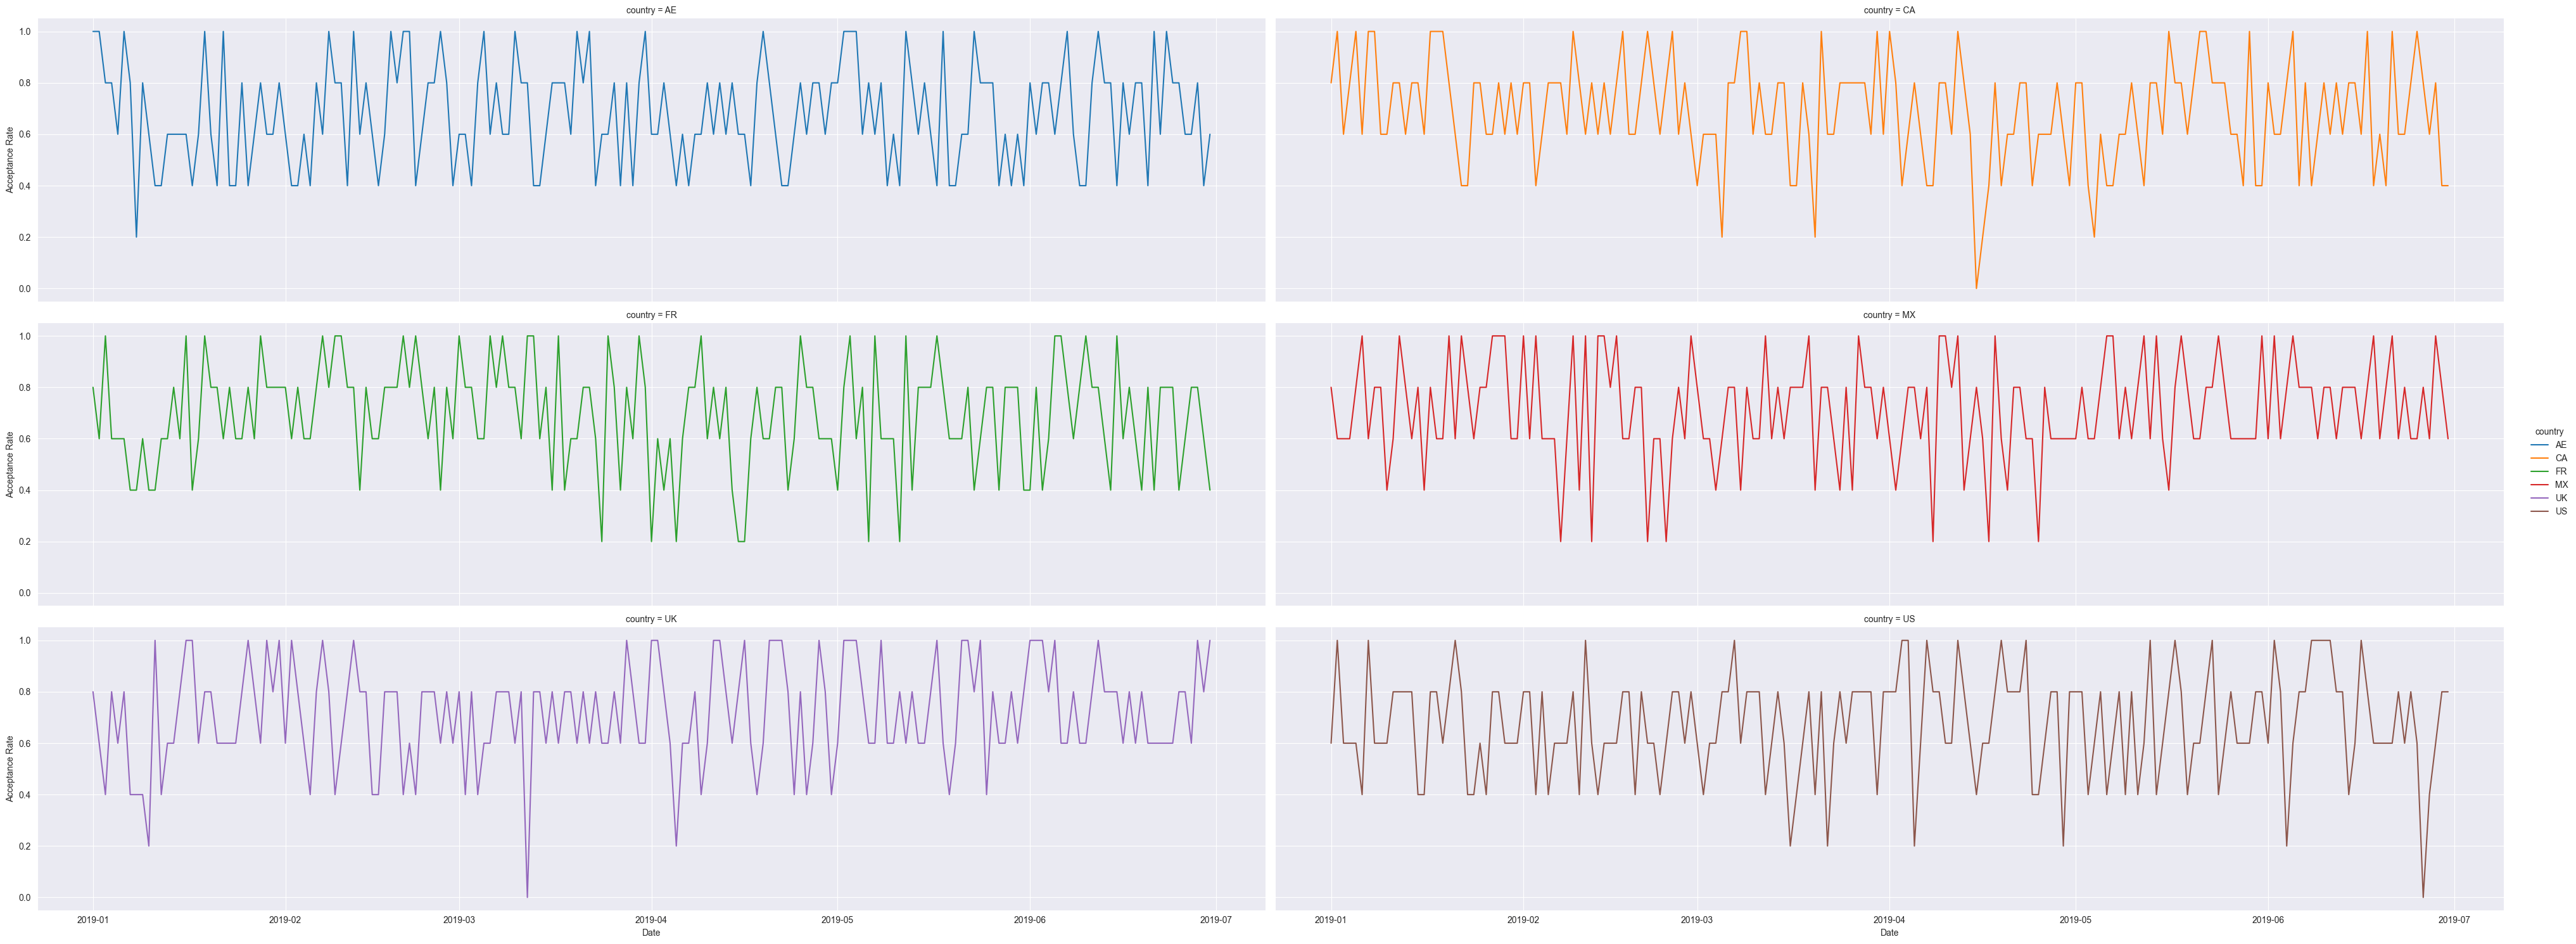

In [ ]:
# use relplot, displot, and catplot

def acceptance_rate_by_time_criterion(df, time_criterion):
    # Group by time_criterion and calculate the acceptance_rate
    groupby_columns = [time_criterion] + ['country']


    result = df.groupby(groupby_columns).agg(
        total_transactions=('is_accepted', 'size'),
        # amount_usd=('amount_usd', 'sum'),
        accepted_transactions=('is_accepted', lambda x: (x == True).sum())
    ).reset_index()
    result['acceptance_rate'] = result['accepted_transactions'] / result['total_transactions']
    return result

criterion = 'date'
result = acceptance_rate_by_time_criterion(df, criterion)
sns.relplot(result, x=criterion, y='acceptance_rate', kind="line", col='country', col_wrap=2, hue='country', height=5, aspect=4).set_axis_labels('Date','Acceptance Rate')


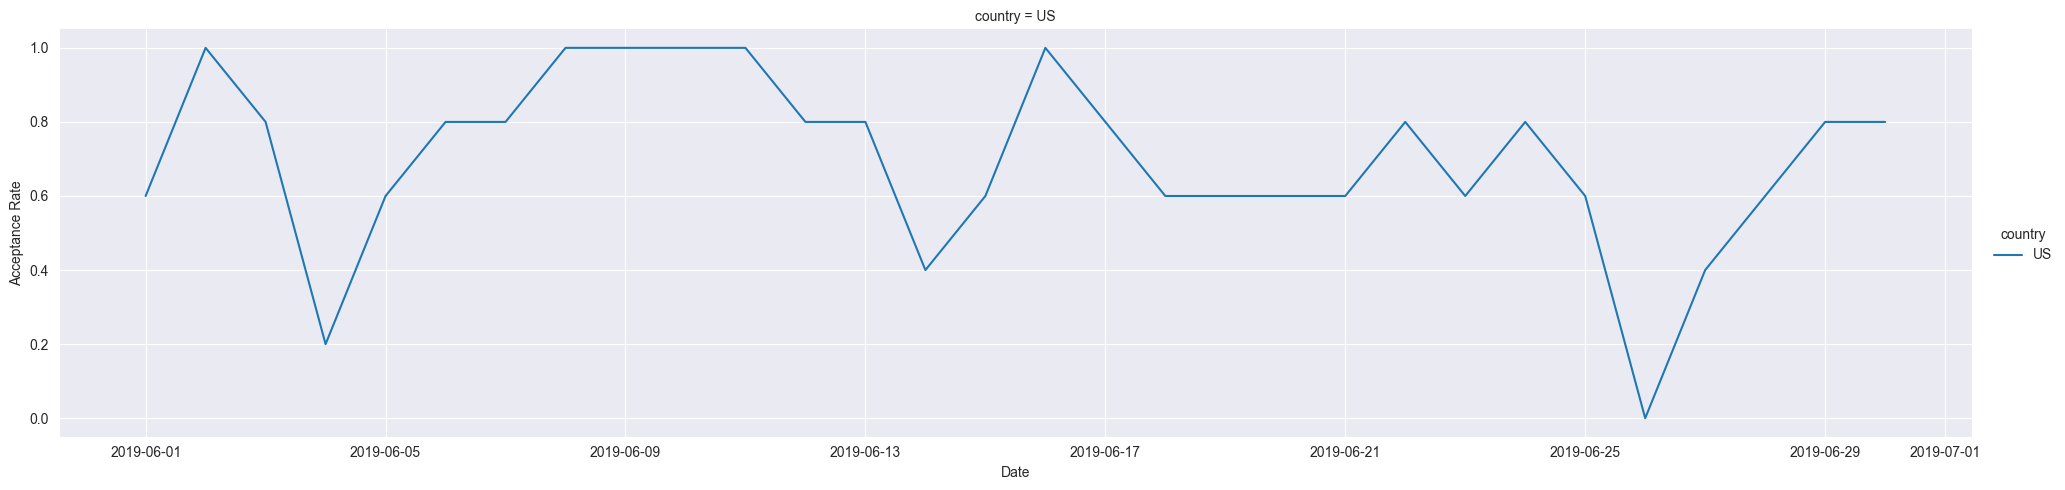

In [187]:
criterion = 'date'
result = acceptance_rate_by_time_criterion(df, criterion)
sns.relplot(result[(result['country']=="US")*(pd.to_datetime(result['date']).dt.month==6)], x=criterion, y='acceptance_rate', kind="line", col='country', hue='country', aspect=4).set_axis_labels('Date','Acceptance Rate')

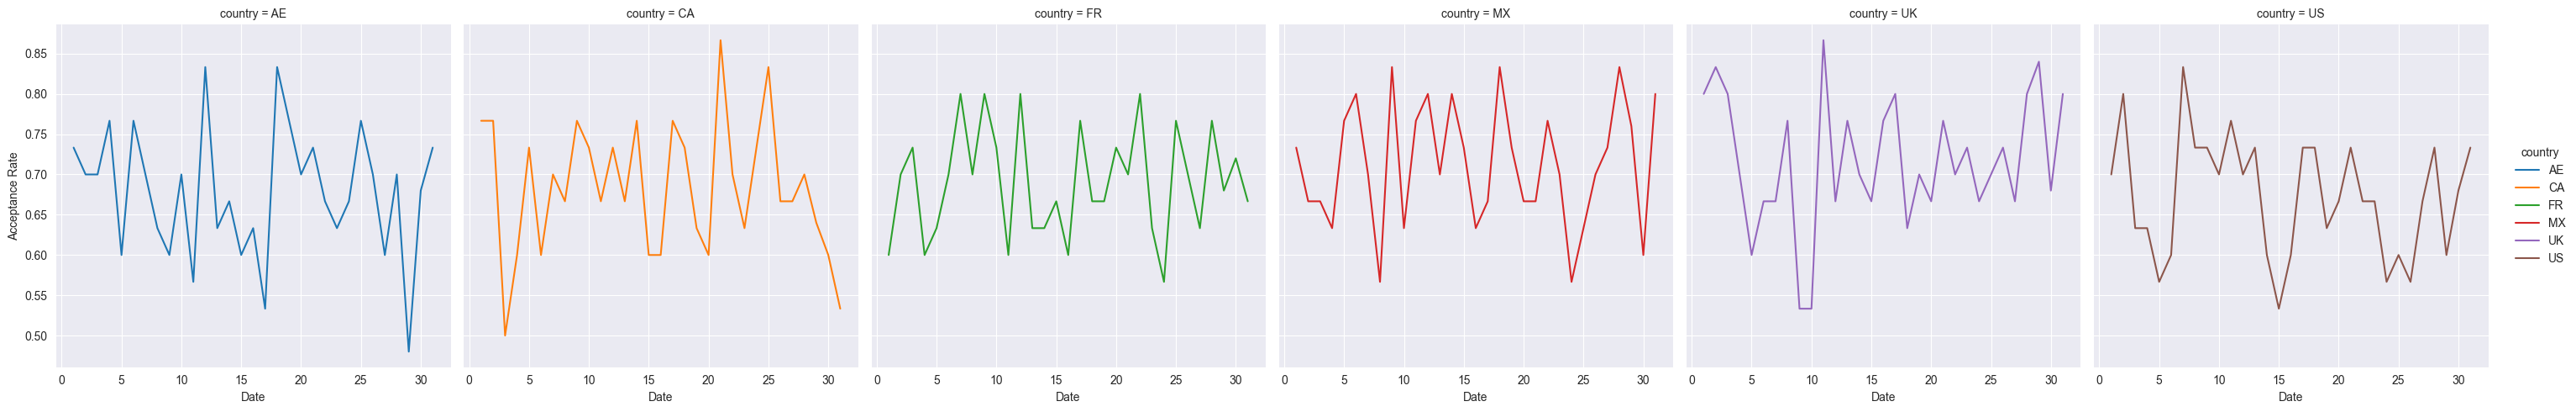

In [188]:
criterion = 'day_of_month'
result = acceptance_rate_by_time_criterion(df, criterion)
sns.relplot(result, x=criterion, y='acceptance_rate', kind="line", col='country', hue='country',).set_axis_labels('Date','Acceptance Rate') #'Acceptance Rate over Time by country

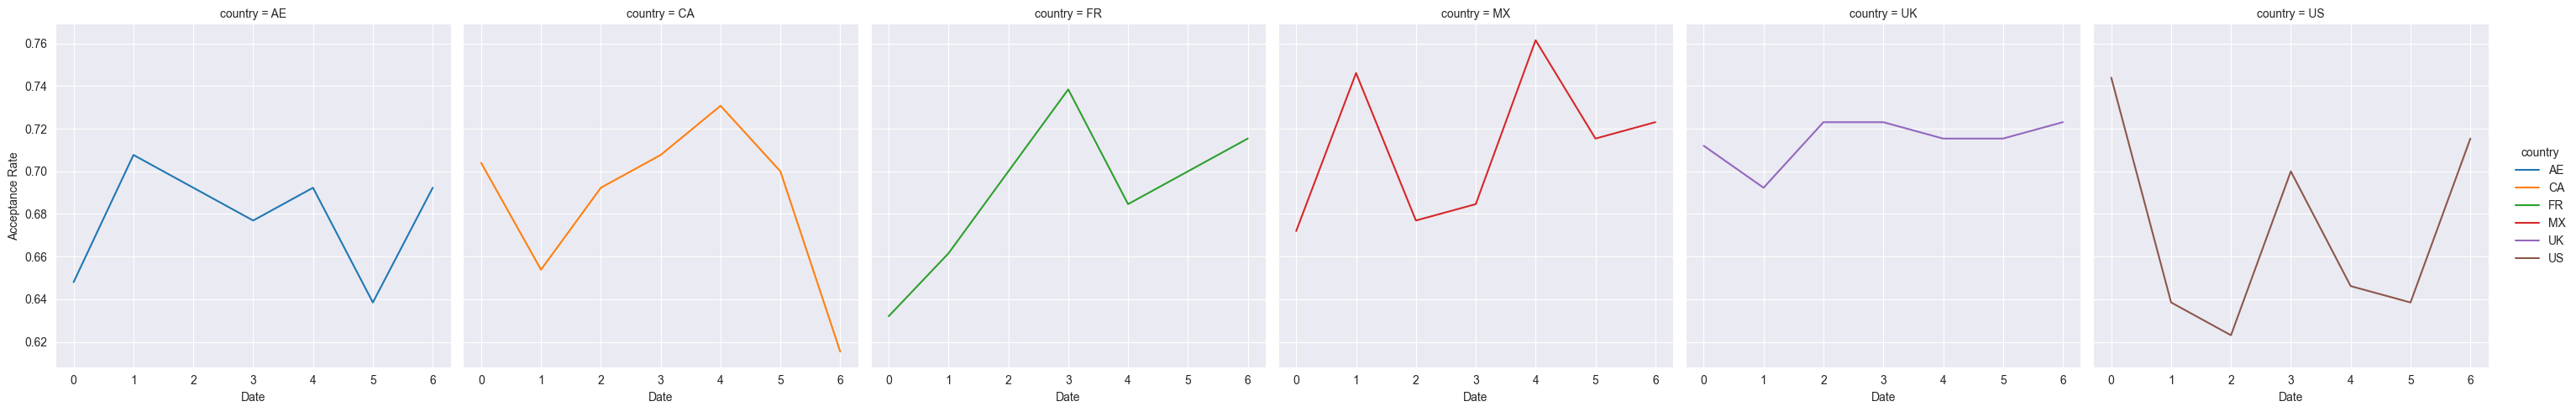

In [189]:
criterion = 'day_of_week'
result = acceptance_rate_by_time_criterion(df, criterion)
sns.relplot(result, x=criterion, y='acceptance_rate', kind="line", col='country', hue='country',).set_axis_labels('Date','Acceptance Rate') #'Acceptance Rate over Time by country

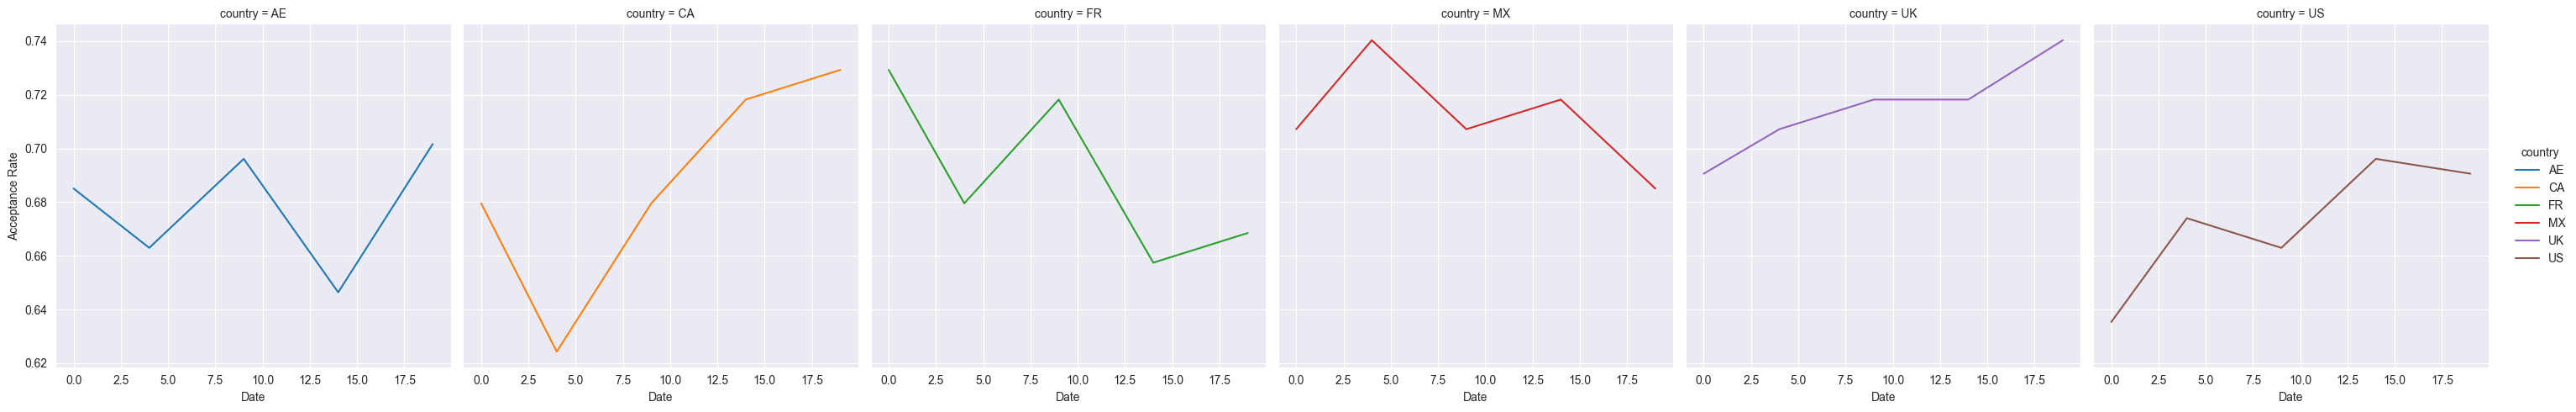

In [190]:
criterion = 'hour_of_day'
result = acceptance_rate_by_time_criterion(df, criterion)
sns.relplot(result, x=criterion, y='acceptance_rate', kind="line", col='country', hue='country',).set_axis_labels('Date','Acceptance Rate') #'Acceptance Rate over Time by country

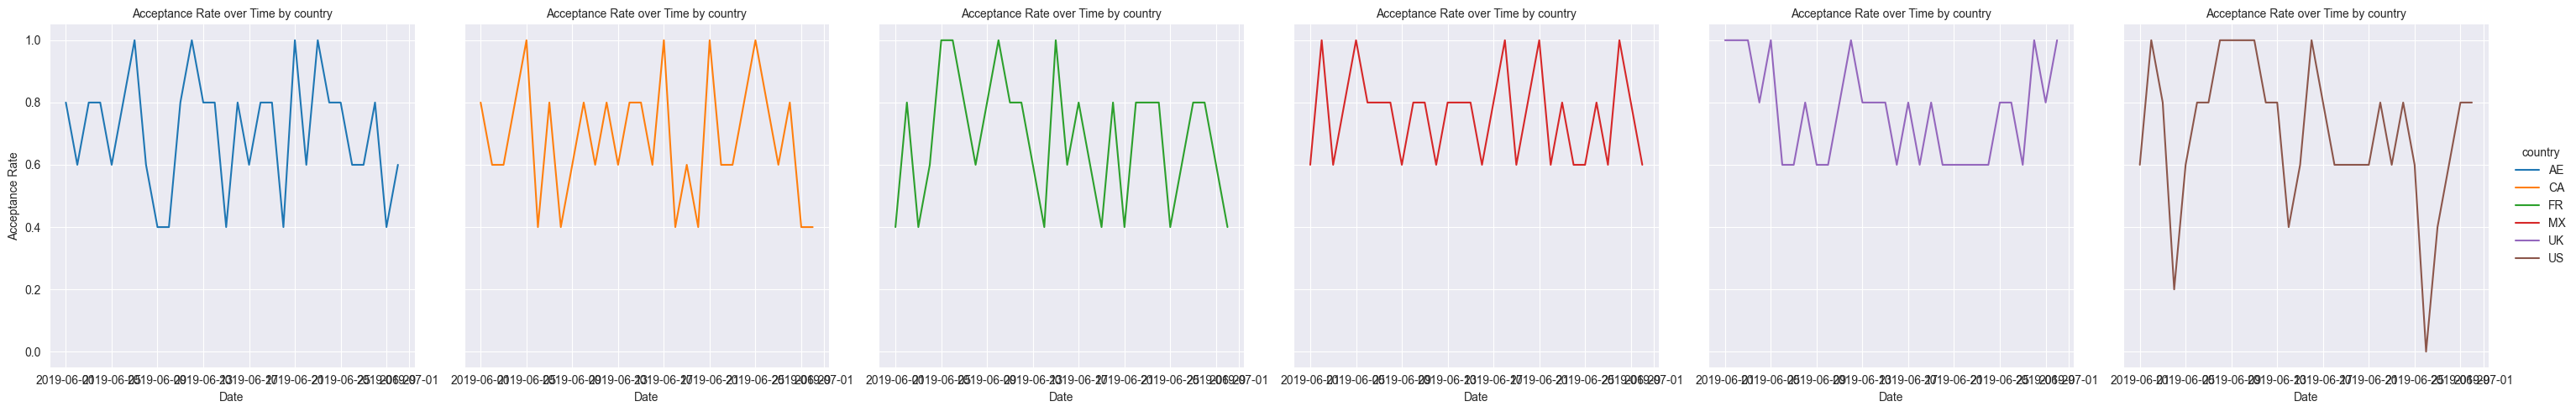

In [191]:
criterion = 'date'
result = acceptance_rate_by_time_criterion(df, criterion)
sns.relplot(result[pd.to_datetime(result['date']).dt.month==6], x=criterion, y='acceptance_rate', kind="line", col='country', hue='country',).set_titles('Acceptance Rate over Time by country').set_axis_labels('Date','Acceptance Rate')


<Axes: xlabel='date', ylabel='declined_amount_usd'>

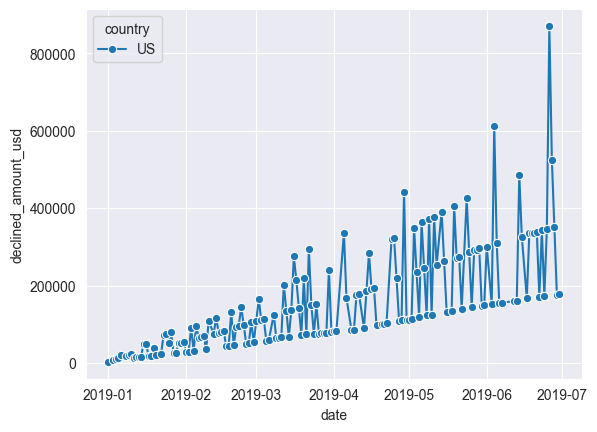

In [192]:
# We see that in fact over 800,000 USD were declined on the 26th of June 2024
df_declined = df[df['state'] == 'DECLINED']

df_declined_grouped = df_declined.groupby(['date', 'country']).agg(
    declined_amount_usd=('amount_usd', 'sum')
).reset_index()

sns.lineplot(data=df_declined_grouped[df_declined_grouped['country']=="US"], x='date', y='declined_amount_usd', hue='country', marker='o')


In [193]:
df[df['date'].astype(str)=='2019-06-26'][df['country']=="US"].sort_values('date_time')

/var/folders/jc/1hl9c7nx1h15zywjnz8mmrd00000gn/T/ipykernel_19878/2519064754.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['date'].astype(str)=='2019-06-26'][df['country']=="US"].sort_values('date_time')


,date_time,state,cvv_provided,amount,country,currency,rates,chargeback,is_accepted,amount_usd,date,day_of_month,day_of_week,hour_of_day
2233,2019-06-26 00:00:00+00:00,DECLINED,False,173592.20,US,USD,"{'CAD': 1.3578706311839093, 'EUR': 0.694386280...",False,False,173592.20,2019-06-26,26,2,0
5053,2019-06-26 04:48:00+00:00,DECLINED,False,173504.33,US,USD,"{'CAD': 1.3578706311839093, 'EUR': 0.694386280...",False,False,173504.33,2019-06-26,26,2,4
1849,2019-06-26 09:36:00+00:00,DECLINED,False,174089.92,US,USD,"{'CAD': 1.3578706311839093, 'EUR': 0.694386280...",False,False,174089.92,2019-06-26,26,2,9
424,2019-06-26 14:24:00+00:00,DECLINED,False,174471.96,US,USD,"{'CAD': 1.3578706311839093, 'EUR': 0.694386280...",False,False,174471.96,2019-06-26,26,2,14
1186,2019-06-26 19:12:00+00:00,DECLINED,False,174932.32,US,USD,"{'CAD': 1.3578706311839093, 'EUR': 0.694386280...",False,False,174932.32,2019-06-26,26,2,19


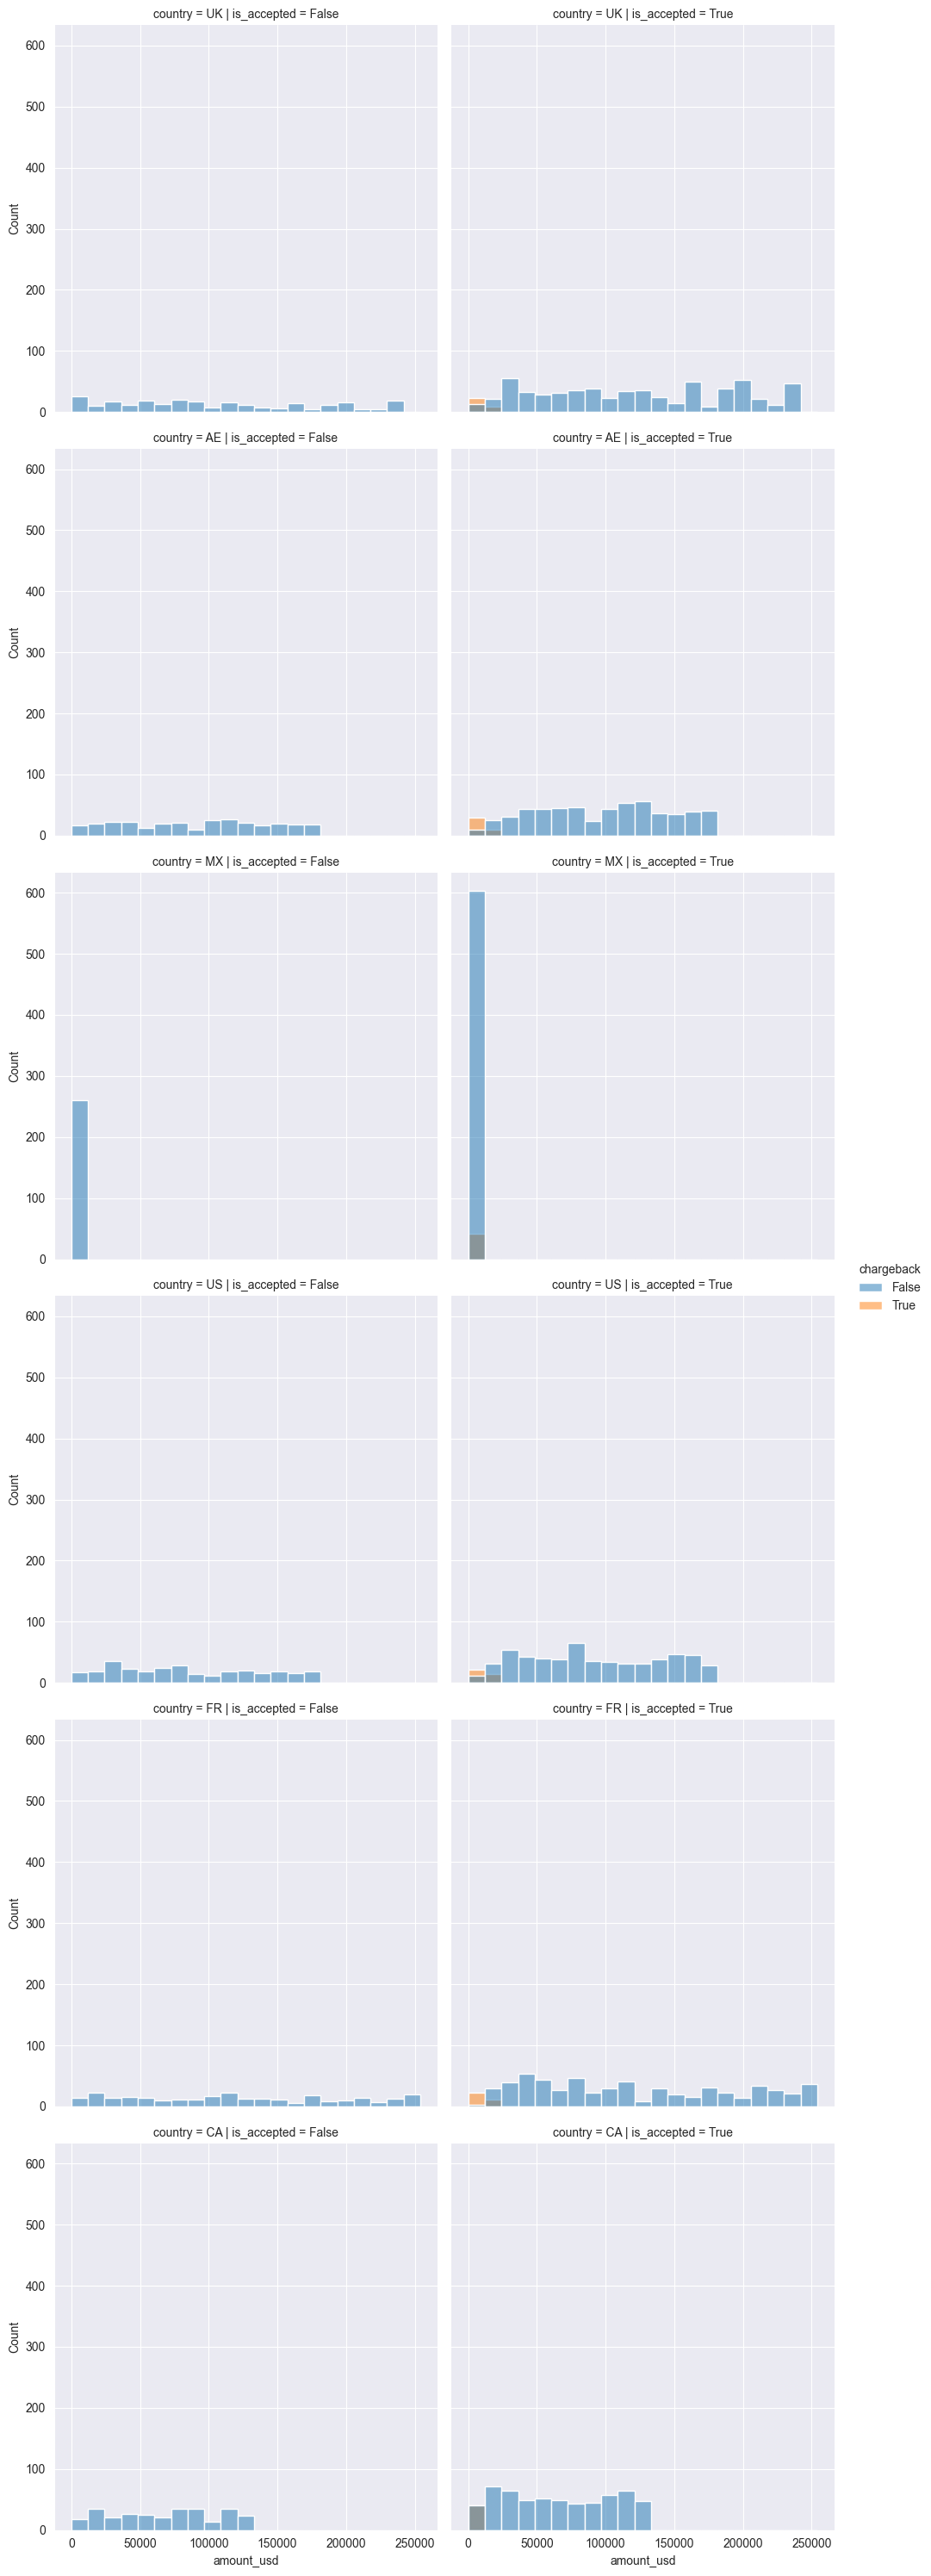

In [194]:
# sns.displot(df, x='is_accepted', row='country', hue='chargeback')
sns.displot(df, x='amount_usd', row='country', col='is_accepted', hue='chargeback')

- We notice that only accepted transactions are being charged back. Further, only 4.1% of transactions are being charged back (c.f. eda_reports/report_chargeback.html)
- We also notice that chargeback amounts are very small.
- My knowledge on chargebacks is limited, but at worst it might have to do with fraud. Therefore this is something I must discuss with the responsible stakeholder in order to get a better understanding.

# Insights
- Present the volume of declined payments in USD
- Analyse the root causes for the decline in the acceptance rate
- Provide well-justified solutions, recommendations, and next steps that you would take if given
more time, additional data, and deeper business knowledge.

- We notice from our EDA (eda_reports/report_acceptance.html) that CVV is provided < 1% of the time, although it is know to be an important verification mechanism. Enforcing CVV more regularily could increase the acceptance rate.
- Further, we have 30 transactions each day for each country in the dataset.
- We also notice from the API description that more verification mechanisms are available.
  - The available mechanisms are:
    - Payment method (e.g. Visa)
    - expiry month and expiry year can guarantee the card is still valid
    - The accuracy of the Card Holder Name is not very significant in Germany to the best of my knowledge, but could be a relevant verification factor in other countries. 
  - If implemented and the data is available, I would suggest to take them into account for our analysis to be more granular.
  - If not implemented, I would suggest enforcing them more in order to increase the acceptance rate.

Hypothesis:
- We have recurring customers each month. 
- Further, we have 30 transactions each day for each country in the dataset.
- The acceptance rate could depend on the individual customer profile. 
- Understanding which customer is making a transaction which day thanks to a customer id could help to identify customers who face problems repeatedly.